In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import GPyOpt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os

from bopt_setup import load_predict, perturb, get_noise_f
from keras.preprocessing import image

Using TensorFlow backend.


# Images

<b>Images:</b> Stock photos taken from [Pexels](https://www.pexels.com/).

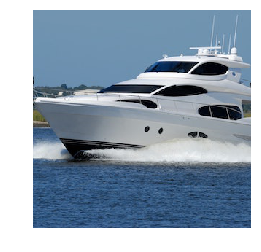

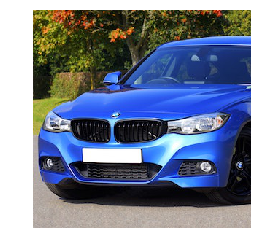

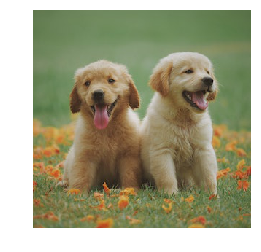

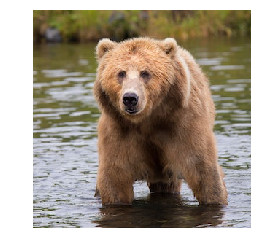

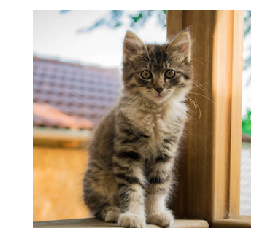

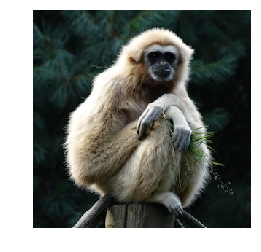

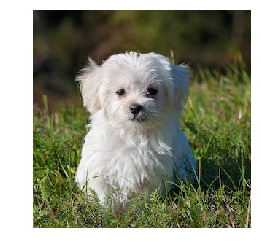

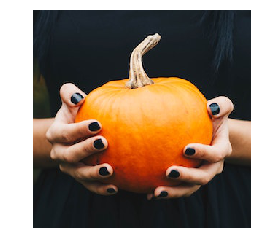

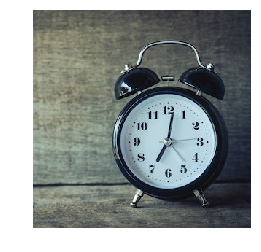

In [3]:
img_dir = 'images/'

# Specify image dimensions
dim = 299

# Load images
all_images = {}
for filename in os.listdir(img_dir):
    if not filename.startswith('.'):
        img = image.load_img(img_dir + filename, target_size = (dim, dim)) # We assume all images have the same dimensions
        img = image.img_to_array(img)
        all_images[filename.split('.')[0]] = img

# Display images
for key, vals in all_images.items():
    fig2 = plt.figure()
    plt.axis('off')
    plt.imshow(vals.astype(np.uint8))

# Bayesian Optimization

## Model & Noise

In [4]:
# Model and noise settings
noise_f = 'perlin'             # ''perlin', 'osimplex'
model_name = 'IncV3'   # 'IncV3'

# Load model and noise function
predict_prob = load_predict(model_name)
noise_func, bounds = get_noise_f(dim, noise_f)

## Constraints

In [5]:
all_images.keys()

dict_keys(['Boat', 'Blue Car', 'Golden Retriever', 'Brown Bear', 'Cat', 'Gibbon', 'Maltese Dog', 'Pumpkin', 'Analog Clock'])

Change this for various experiments:

In [6]:
max_norm = 8
max_query = 10
init_query = 5
img_key = 'Cat'          # choose filename from directory

## Initialization

We assume the classifier correctly labels the original image since that we will try to minimize the highest label of the original image.

In [7]:
# Get original image and index
orig_img = all_images[img_key]
probs, _ = predict_prob(orig_img.reshape((dim, dim, 3)))
orig_ind = np.argmax(probs)

In [8]:
# Initial queries for Bayesian optimization
np.random.seed(0)
feasible_space = GPyOpt.Design_space(space = bounds)        
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_space, init_query)

GPyOpt minimizes the objective function. For here, the objective function is the difference between the probability of the original label and the 2nd highest probability score. If this remains positive then the original label is still the highest probability score. Otherwise, it's not the top prediction.

In [9]:
# Objective function
class objective_func:
    def __init__(self):
        pass
    def f(self, params):
        params = params[0]
        payload = perturb(orig_img, max_norm, noise_func(params))
        scores, decoded = predict_prob(payload)
        orig_score = scores[orig_ind]
        return orig_score - decoded[1][2] 

In [10]:
best_f = 1
queries = 0
obj_func = objective_func()

# Gaussian process and Bayesian optimization
objective = GPyOpt.core.task.SingleObjective(obj_func.f, num_cores = 1)
model = GPyOpt.models.GPModel(exact_feval = False, optimize_restarts = 5, verbose = False)
aquisition_opt = GPyOpt.optimization.AcquisitionOptimizer(feasible_space)
acquisition = GPyOpt.acquisitions.AcquisitionLCB(model, feasible_space, optimizer = aquisition_opt)
evaluator = GPyOpt.core.evaluators.Sequential(acquisition, batch_size = 1)

## Attack

In [11]:
BOpt = GPyOpt.methods.ModularBayesianOptimization(model, feasible_space, objective, acquisition, evaluator, initial_design)

while queries < max_query and best_f > 0:
    queries += 1
    BOpt.run_optimization(max_iter = 1)
    best_f = BOpt.fx_opt
    if queries % 5 == 0: print('Query %i, Objective Function %0.2f' % (queries, best_f)) # Print every 5th query

if best_f > 0:
    print('Attack failed.')
else:
    print('Success!')
    
# Evaluate best parameters
params = BOpt.x_opt
payload = perturb(orig_img, max_norm, noise_func(params))
scores, decoded = predict_prob(payload)

Success!


# Results

These are the best parameters found. Note the parameters we use here for Perlin and OpenSimplex noise is the frequency rather than period, so take the reciprocal if you want to test it on our visualization notebooks.

In [12]:
print('Objective function value:', best_f)
print('Parameters:', params)

Objective function value: [0.]
Parameters: [0.04378512 5.58796336 1.        ]


## Visualize Results

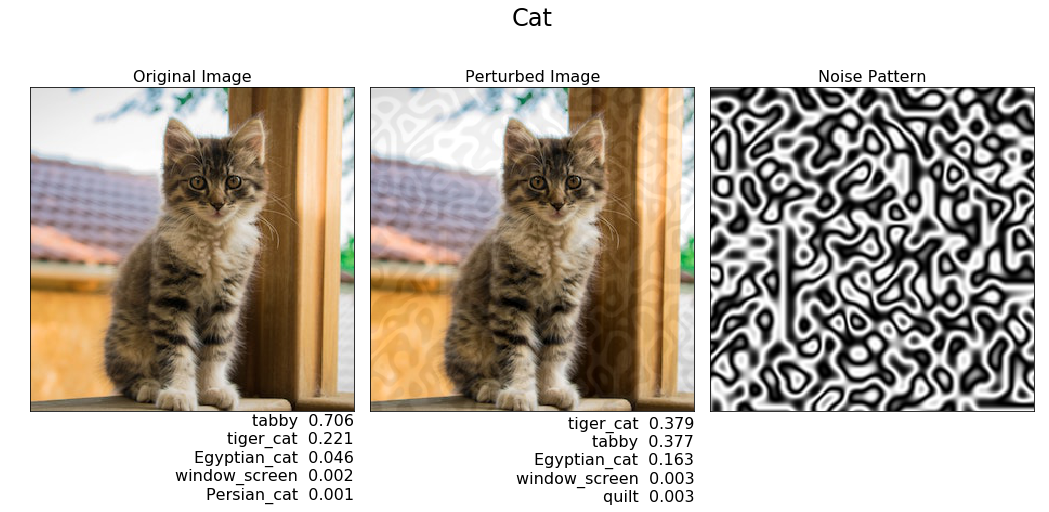

In [13]:
# Display images and probabilities
fig = plt.figure(figsize = (18, 8))
plt.subplots_adjust(wspace = 0.05)
plt.title(img_key, fontsize = 24)
plt.axis('off')

# Original image
ax = fig.add_subplot(1, 3, 1)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis = 'both', which = 'both', length = 0)
ax.set_title('Original Image', size = 16)
plt.imshow(orig_img.astype(np.uint8))
scores, decoded = predict_prob(orig_img.reshape((dim, dim, 3)))
plt.xlabel('\n'.join((item[1]  + '  %.3f' % item[2]) for item in decoded[:5]), horizontalalignment = 'right', x = 1, size = 16)

# Altered image
ax = fig.add_subplot(1, 3, 2)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis = 'both', which = 'both', length = 0)
ax.set_title('Perturbed Image', size = 16)
plt.imshow(payload.astype(np.uint8))
scores, decoded = predict_prob(payload.reshape((dim, dim, 3)))
plt.xlabel('\n'.join((item[1]  + '  %.3f' % item[2]) for item in decoded[:5]), horizontalalignment = 'right', x = 1, size = 16)

# Noise pattern
ax = fig.add_subplot(1, 3, 3)    
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis = 'both', which = 'both', length = 0)
ax.set_title('Noise Pattern', size = 16)
plt.imshow((noise_func(params) + 1) / 2)